Name: Holly Kular\
Date: 01-16-2025\
Email: hkular@ucsd.edu\
Description: use CEBRA hypothesis workflow

In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colormaps
import cebra
import cebra.models
from cebra import CEBRA

In [2]:
# which model do we want to explore
afc = 2
coh = 'lo'
mod = 0

In [3]:
# load RNN model and trials

if sys.platform.startswith('linux'):
        data_dir = f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/rdk_70_30_{afc}afc/feedforward_only/{coh}_coh"
else:
        data_dir = f"/Volumes/serenceslab/holly/RNN_Geo/data/rdk_70_30_{afc}afc/feedforward_only/{coh}_coh"
        
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat') and not f.startswith('._')]# Get all the trained models (should be 40 .mat files)
model_path = os.path.join(data_dir, mat_files[mod]) 
model = loadmat(model_path)   
data_file = f"{data_dir}/Trials1000_model{model_path[-7:-4]}_neutral.npz"
data = np.load(data_file) #fr1 fr3 outs labs


In [9]:
# reshape firing rate data and get trial labels
layer = 3
fr = data[f'fr{layer}'] # shape (1000, 250, 200) trials x time x units
labels = data['labs']  # labels are 1D, shape (1000,)trials

n_trials = fr.shape[0]
n_timepoints = fr.shape[1]
n_units = fr.shape[2]

# collapse across trials and timepoints
fr_col = fr.reshape((n_trials*n_timepoints, n_units))

# extend trial labels by timepoints
expanded_labels = np.repeat(labels, n_timepoints)

# shuffle for control model
expanded_labels_shuffled = np.random.permutation(expanded_labels)

expected = expanded_labels == 0
unexpected = expanded_labels != 0

In [10]:
# build CEBRA-Behavior model
    # uses behavior info (trial type)
    
cebra_stim0_model = CEBRA(
    model_architecture = "offset10-model",
    batch_size = 256,
    temperature = 1,
    learning_rate = 3e-4,
    max_iterations = 100,
    time_offsets = 10,
    distance = "cosine",
    output_dimension = 3,
    conditional = "time_delta",
    device = "cpu",
    verbose = True)

# train model
cebra_stim0_model.fit(fr_col[expected], expanded_labels[expected])
cebra_stim0_model.save("cebra_stim0_model.pt")



cebra_stim1t5_model = CEBRA(
    model_architecture = "offset10-model",
    batch_size = 256,
    temperature = 1,
    learning_rate = 3e-4,
    max_iterations = 100,
    time_offsets = 10,
    distance = "cosine",
    output_dimension = 3,
    conditional = "time_delta",
    device = "cpu",
    verbose = True)

# train model
cebra_stim1t5_model.fit(fr_col[unexpected], expanded_labels[unexpected])
cebra_stim1t5_model.save("cebra_stim1t5_model.pt")


cebra_allstims_model = CEBRA(
    model_architecture = "offset10-model",
    batch_size = 256,
    temperature = 1,
    learning_rate = 3e-4,
    max_iterations = 100,
    time_offsets = 10,
    distance = "cosine",
    output_dimension = 3,
    conditional = "time_delta",
    device = "cpu",
    verbose = True)

# train model
cebra_allstims_model.fit(fr_col, expanded_labels)
cebra_allstims_model.save("cebra_allstims_model.pt")



pos: -0.5637 neg:  5.9807 total:  5.4170 temperature:  1.0000: 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]
pos: -0.6651 neg:  6.0638 total:  5.3987 temperature:  1.0000: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]
pos: -0.6769 neg:  5.9564 total:  5.2795 temperature:  1.0000: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


In [11]:
# build CEBRA-shuffled models
    # train on shuffled neural data as control
    
cebra_shuffled_model = CEBRA(
    model_architecture = "offset10-model",
    batch_size = 256,
    temperature = 1,
    learning_rate = 3e-4,
    max_iterations = 100,
    time_offsets = 10,
    distance = "cosine",
    output_dimension = 3,
    conditional = "time_delta",
    device = "cpu",
    verbose = True)

# train model
cebra_shuffled_model.fit(fr_col, np.random.permutation(expanded_labels))
cebra_shuffled_model.save("cebra_shuffled_model.pt")


pos: -0.6870 neg:  6.0834 total:  5.3964 temperature:  1.0000: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


In [12]:
# Load models and get embeddings

# CEBRA-Behavior: stim 0
cebra_stim0_model = cebra.CEBRA.load("cebra_stim0_model.pt")
cebra_stim0 = cebra_stim0_model.transform(fr_col)

# CEBRA-Behavior: stim1-5
cebra_stim1t5_model = cebra.CEBRA.load("cebra_stim1t5_model.pt")
cebra_stim1t5 = cebra_stim1t5_model.transform(fr_col)

# CEBRA-Behavior: all stims
cebra_allstims_model = cebra.CEBRA.load("cebra_allstims_model.pt")
cebra_allstims = cebra_allstims_model.transform(fr_col)


# CEBRA-Behavior with shuffled labels all stims
cebra_shuffled_model = cebra.CEBRA.load("cebra_shuffled_model.pt")
cebra_shuffled_train = cebra_shuffled_model.transform(fr_col)



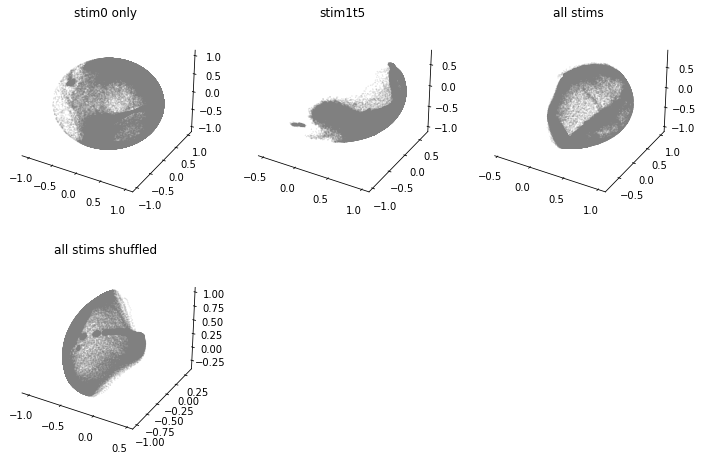

In [16]:
# Visualize embeddings
layer = 3
fig=plt.figure(figsize=(12,8))

ax1=plt.subplot(231, projection = '3d')
ax2=plt.subplot(232, projection = '3d')
ax3=plt.subplot(233, projection = '3d')
ax4=plt.subplot(234, projection = '3d')

ax1=cebra.plot_embedding(ax=ax1, embedding=cebra_stim0, embedding_labels="grey", title='stim0 only')
ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_stim1t5, embedding_labels="grey", title='stim1t5')
ax3=cebra.plot_embedding(ax=ax3, embedding=cebra_allstims, embedding_labels="grey", title='all stims')
ax4=cebra.plot_embedding(ax=ax4, embedding=cebra_shuffled_train, embedding_labels="grey", title='all stims shuffled')

fname = f"/Volumes/serenceslab/holly/RNN_Geo/05_CEBRA/{afc}afc_{coh}/hypothesis_fr{layer}_mod{mod}"
plt.savefig(fname) 
plt.show()

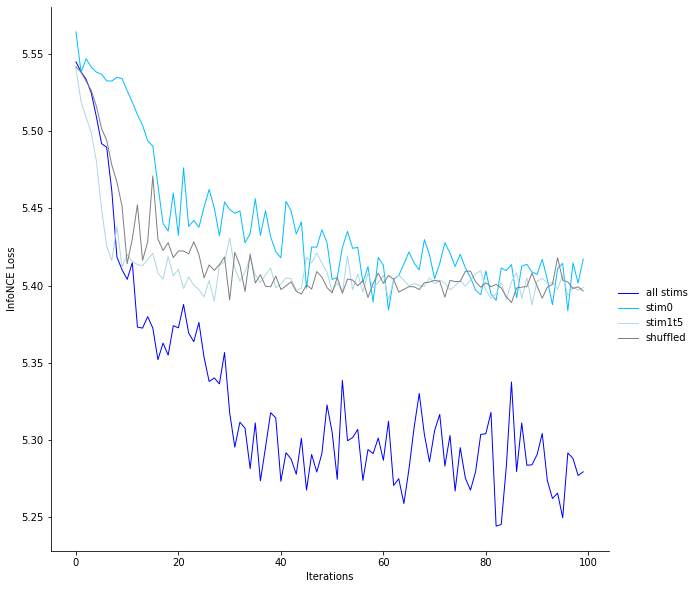

In [23]:
# visualize loss
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

ax = cebra.plot_loss(cebra_allstims_model, color='blue', label='all stims', ax=ax)
ax = cebra.plot_loss(cebra_stim0_model, color='deepskyblue', alpha=1, label='stim0', ax=ax)
ax = cebra.plot_loss(cebra_stim1t5_model, color='lightblue', alpha=1,label='stim1t5', ax=ax)

ax = cebra.plot_loss(cebra_shuffled_model, color='gray', label='shuffled', ax=ax)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iterations')
ax.set_ylabel('InfoNCE Loss')
plt.legend(bbox_to_anchor=(1,.5), frameon = False)

fname = f"/Volumes/serenceslab/holly/RNN_Geo/05_CEBRA/{afc}afc_{coh}/hypothesis_loss_fr{layer}_mod{mod}"
plt.savefig(fname) 
plt.show()